## [pyKNEEr](https://github.com/sbonaretti/pyKNEEr)

# [Relaxometry of Femoral Knee Cartilage](https://sbonaretti.github.io/pyKNEEr/relaxometry.html)
# Exponential and linear fitting

- *Exponential* fitting is computationally expensive but more accurate
- *Linear fitting* is faster as data are transformed to their log and then linearly interpolated. However, linear fitting is less accurate because the nonlinear logaritmic transform provides larger weight to outliers  

The fitting is computed:  
- *directly* on the acquired images or after *rigid registration* of the following echo to the first echo  
- voxel-wise, i.e. for each voxel the Echo Times (dicom tag: (0018,0081)) are the x-variable and the voxel intensities in each acquisition are the y-variable
- only in the mask volume to have short computation time

---

*Automatic data download for the reproducibility of this notebook:*
- Download input images from Zenodo and image file list from GitHub:

In [ ]:
import os
import wget
from zipfile import ZipFile 

In [ ]:
# local folder  
local_folder_name  = "./inHouse/"
# Zenodo variables
input_URL          = "https://zenodo.org/record/2583184/files/"
zipped_folder_name = "inHouse_preprocessed.zip" 
zipped_segm_name   = "inHouse_segmented.zip"
# GitHub variables
raw_url            = "https://raw.githubusercontent.com/sbonaretti/pyKNEEr/master/publication/data/"
input_file_name    = "image_list_relaxometry_fitting_inHouse_t1rho.txt"

In [ ]:
# create local folder for dataset
if not os.path.isdir(local_folder_name):
    os.mkdir(local_folder_name)
    print ("folder " + local_folder_name + " created")

In [ ]:
# download zipped folder from Zenodo
wget.download(input_URL + zipped_folder_name, local_folder_name + zipped_folder_name) 

In [ ]:
# download segmented images
wget.download(input_URL + zipped_segm_name, local_folder_name + zipped_segm_name)

In [ ]:
# unzip image folder
with ZipFile(local_folder_name + zipped_folder_name, 'r') as zip: 
    zip.extractall(local_folder_name) 

In [ ]:
# unzip segmented images
with ZipFile(local_folder_name + zipped_segm_name, 'r') as zip: 
    zip.extractall(local_folder_name) 

In [ ]:
# download input file from GitHub
wget.download(raw_url + input_file_name, "./" + input_file_name)

---

## Import packages

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pykneer import pykneer_io         as io
from pykneer import relaxometry_for_nb as rel
import itk
import itkwidgets
from itkwidgets import view

## Image information

Inputs:   
- `input_file_name` contains the list of the images used to calculate the relaxation maps
- `method` is `0` if fitting is linear, `1` if fitting is exponential
- `registration_flag` is `0` for no registration, `1` for rigid registration
- `output_file_name` contains average and standard deviation of the fitting maps 

In [3]:
# input_file_name   = "./image_list_relaxometry_fitting_inHouse_t1rho.txt" # commented out because downloaded from GitHub
method_flag       = 1  #0 = linear, 1 = exponential
registration_flag = 1 # 0 = no rigid registration, 1 = execute rigid registration
n_of_cores        = 4
output_file_name  = "exp_fit_aligned_inHouse_T1rho.csv"

#### Read image data
- `image_data` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [4]:
image_data = io.load_image_data_fitting(input_file_name, method_flag, registration_flag)

-> information loaded for 4 subjects
-> for each subjects there are 4 acquisitions


## Calculate fitting maps

#### Align acquisitions 
Images are aligned rigidly to remove occational subject motion among acquisitions   

Note: This step is optional and can be skipped, given that:
 - When images are aligned, the fitting is calculated on interpolated values obtained with rigid registration
 - When images are not aligned, the fitting is calculated on original intensities, but images might not be aligned

In [5]:
if registration_flag == 1:
    rel.align_acquisitions(image_data, n_of_cores)

-> 01_cubeQuant_1_orig.mha
-> 03_cubeQuant_1_orig.mha
-> 02_cubeQuant_1_orig.mha
-> 04_cubeQuant_1_orig.mha
-> Acquisitions aligned
-> The total time was 565.27 seconds (about 9 min)


#### Compute the fitting

In [6]:
rel.calculate_fitting_maps(image_data, n_of_cores)

-> using exponential fitting 
02_cubeQuant_1_orig.mha
03_cubeQuant_1_orig.mha
01_cubeQuant_1_orig.mha
04_cubeQuant_1_orig.mha


overflow encountered in multiply
overflow encountered in multiply
overflow encountered in multiply
overflow encountered in multiply


-> Fitting maps calculated
-> The total time was 144.93 seconds (about 2 min)


## Visualize fitting maps

#### 2D MAP: For each image, fitting maps at medial and lateral compartments and flattened map

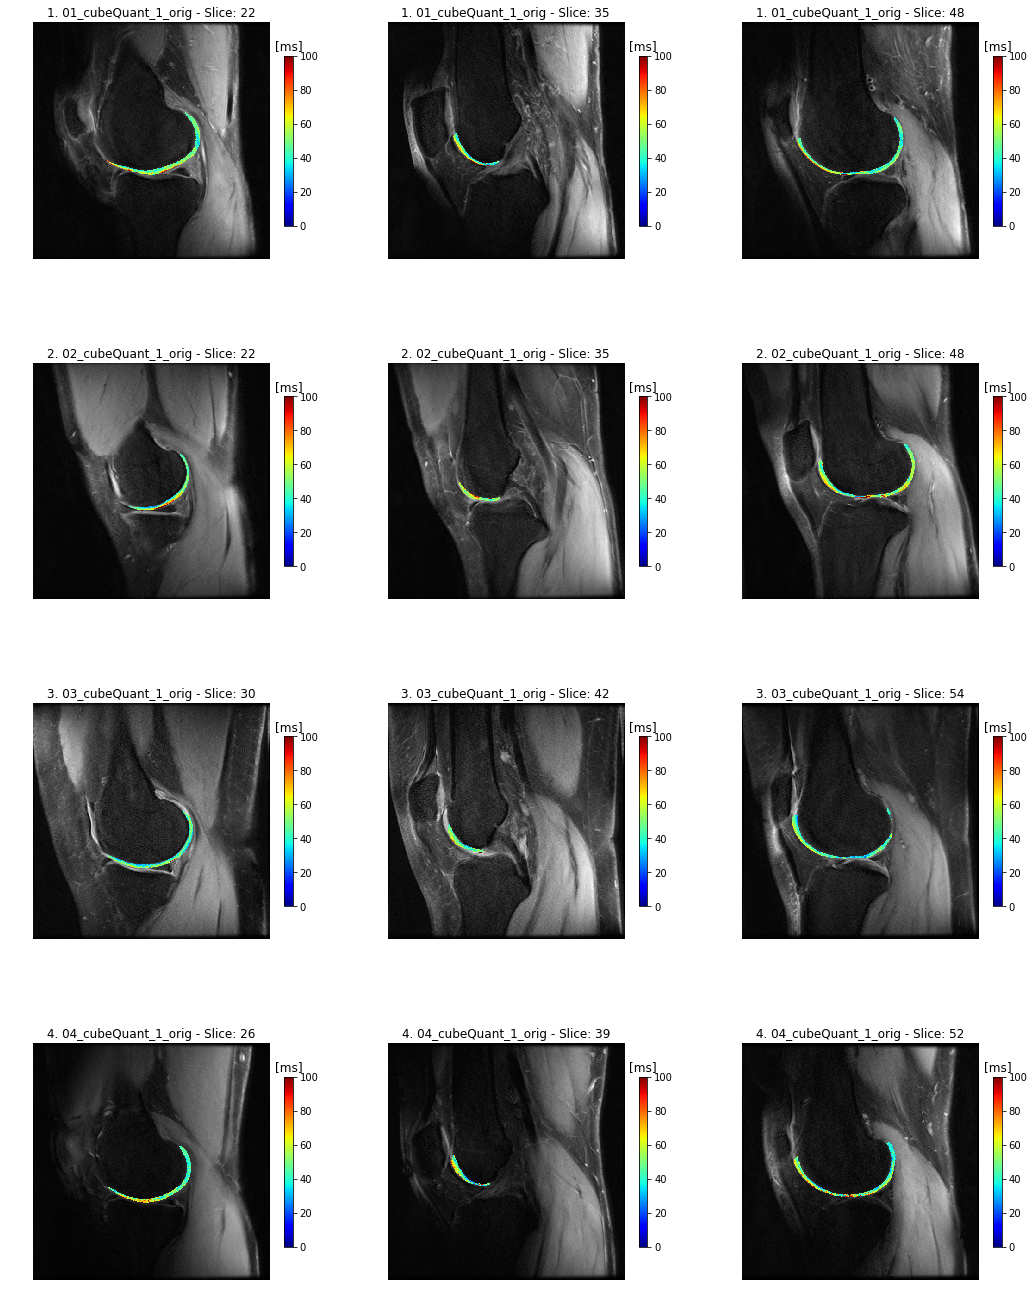

In [7]:
rel.show_fitting_maps(image_data)

#### 3D MAP: Interactive rendering of fitting maps
(The error message "Error creating widget: could not find model" can appear when the notebook is moved to a different folder)

In [8]:
# ID of the map to visualize (first number in the title of the visualization above)
image_ID = 1 -1 # -1 because counting starts from 0

# read image
file_name = image_data[image_ID]["relaxometryFolder"] + image_data[image_ID]["mapFileName"]
image = itk.imread(file_name)

# view
viewer = view(image, gradient_opacity=0.0, ui_collapsed=False, shadow=False)
viewer

Viewer(gradient_opacity=0.01, rendered_image=<itkImagePython.itkImageSS3; proxy of <Swig Object of type 'itkIm…

#### GRAPH: Dots represent the average value of fitting maps per image; bars represents the standard deviation

<Figure size 1296x576 with 0 Axes>

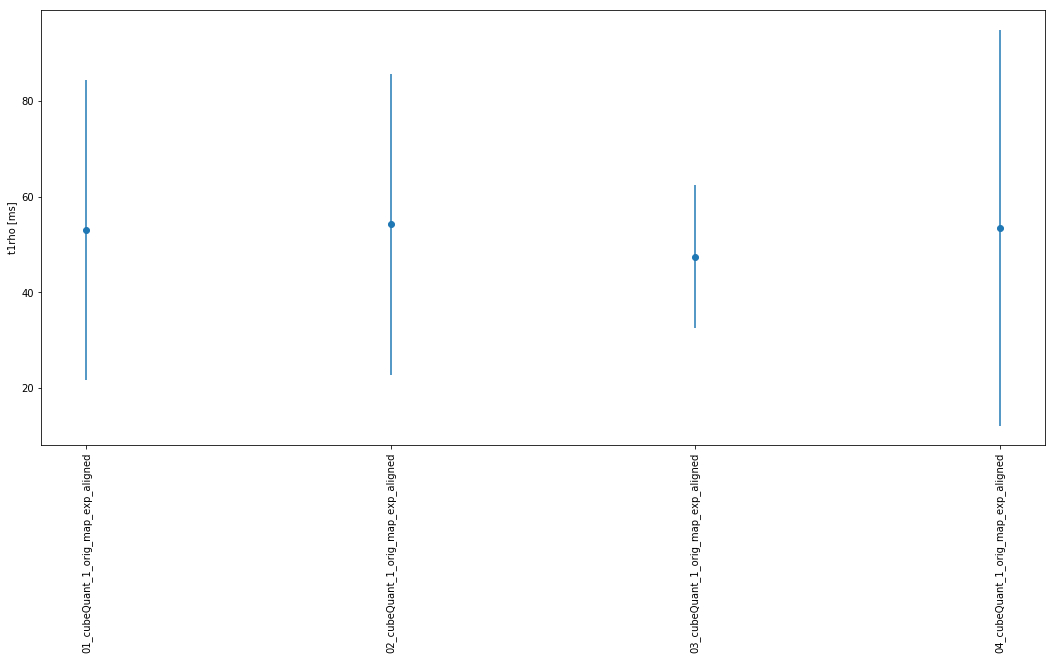

In [9]:
rel.show_fitting_graph(image_data)

#### TABLE: Average and standard deviation of fitting maps per image
The table is saved as a .csv file for subsequent analyisis

In [10]:
rel.show_fitting_table(image_data, output_file_name)

Table saved as: exp_fit_aligned_inHouse_T1rho.csv


,subjects,average,std.dev
1,04_cubeQuant_1_orig_map_exp_aligned.mha,53.05,31.25
2,04_cubeQuant_1_orig_map_exp_aligned.mha,54.27,31.41
3,04_cubeQuant_1_orig_map_exp_aligned.mha,47.46,14.91
4,04_cubeQuant_1_orig_map_exp_aligned.mha,53.50,41.30


### References

[1] Borthakur A., Wheaton A.J., Gougoutas A.J., Akella S.V., Regatte R.R., Charagundla S.R., Reddy R. [*In vivo measurement of T1rho dispersion in the human brain at 1.5 tesla.*](https://www.ncbi.nlm.nih.gov/pubmed/15065163) J Magn Reson Imaging. Apr;19(4):403-9. 2004.  
[2] Li X., Benjamin Ma C., Link T.M., Castillo D.D., Blumenkrantz G., Lozano J., Carballido-Gamio J., Ries M., Majumdar S. [*In vivo T1ρ and T2 mapping of articular cartilage in osteoarthritis of the knee using 3 T MRI.*](https://www.ncbi.nlm.nih.gov/pubmed/17307365) Osteoarthritis Cartilage. Jul;15(7):789-97. 2007.  

### Dependencies

In [11]:
%load_ext watermark
print ("elastix 4.8.0\n")
%watermark -v -m -p SimpleITK,matplotlib,numpy,pandas,scipy,itkwidgets,multiprocessing

elastix 4.8.0

CPython 3.7.1
IPython 6.5.0

SimpleITK unknown
matplotlib 2.2.3
numpy 1.15.1
pandas 0.23.4
scipy 1.1.0
itkwidgets 0.15.2
multiprocessing unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
